In [ ]:
import sys

if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")

In [ ]:
# All Includes

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import tensorflow as tf  # Version 1.0.0 (some previous versions are used in past commits)
from sklearn import metrics

import os

In [ ]:
# Useful Constants

# Those are separate normalised input features for the neural network
INPUT_SIGNAL_TYPES = [
    "body_acc_x_",
    "body_acc_y_",
    "body_acc_z_",
    "body_gyro_x_",
    "body_gyro_y_",
    "body_gyro_z_",
    "total_acc_x_",
    "total_acc_y_",
    "total_acc_z_"
]

# Output classes to learn how to classify
LABELS = [
    "WALKING",
    "WALKING_UPSTAIRS",
    "WALKING_DOWNSTAIRS",
    "SITTING",
    "STANDING",
    "LAYING"
]

In [ ]:
# Note: Linux bash commands start with a "!" inside those "ipython notebook" cells

DATA_PATH = "/Users/hormone03/Desktop/HumanActRecog_LSTM/"

!pwd && ls
os.chdir(DATA_PATH)
!pwd && ls

!python download_dataset.py

!pwd && ls
os.chdir("..")
!pwd && ls

DATASET_PATH = DATA_PATH + "UCI HAR Dataset/"
print("\n" + "Dataset is now located at: " + DATASET_PATH)

In [ ]:
TRAIN = "train/"
TEST = "test/"


# Load "X" (the neural network's training and testing inputs)

def load_X(X_signals_paths):
    X_signals = []

    for signal_type_path in X_signals_paths:
        file = open(signal_type_path, 'r')
        # Read dataset from disk, dealing with text files' syntax
        X_signals.append(
            [np.array(serie, dtype=np.float32) for serie in [
                row.replace('  ', ' ').strip().split(' ') for row in file
            ]]
        )
        file.close()

    return np.transpose(np.array(X_signals), (1, 2, 0))

X_train_signals_paths = [
    DATASET_PATH + TRAIN + "Inertial Signals/" + signal + "train.txt" for signal in INPUT_SIGNAL_TYPES
]
X_test_signals_paths = [
    DATASET_PATH + TEST + "Inertial Signals/" + signal + "test.txt" for signal in INPUT_SIGNAL_TYPES
]

X_train = load_X(X_train_signals_paths)
X_test = load_X(X_test_signals_paths)


# Load "y" (the neural network's training and testing outputs)

def load_y(y_path):
    file = open(y_path, 'r')
    # Read dataset from disk, dealing with text file's syntax
    y_ = np.array(
        [elem for elem in [
            row.replace('  ', ' ').strip().split(' ') for row in file
        ]],
        dtype=np.int32
    )
    file.close()

    # Substract 1 to each output class for friendly 0-based indexing
    return y_ - 1

y_train_path = DATASET_PATH + TRAIN + "y_train.txt"
y_test_path = DATASET_PATH + TEST + "y_test.txt"

y_train = load_y(y_train_path)
y_test = load_y(y_test_path)

In [ ]:
# Input Data

training_data_count = len(X_train)  # 7352 training series (with 50% overlap between each serie)
test_data_count = len(X_test)  # 2947 testing series
n_steps = len(X_train[0])  # 128 timesteps per series
n_input = len(X_train[0][0])  # 9 input parameters per timestep


# LSTM Neural Network's internal structure

n_hidden = 32 # Hidden layer num of features
n_classes = 6 # Total classes (should go up, or should go down)


# Training

learning_rate = 0.0025
lambda_loss_amount = 0.0015
training_iters = training_data_count * 300  # Loop 300 times on the dataset
batch_size = 1500
display_iter = 30000  # To show test set accuracy during training


# Some debugging info

print("Some useful info to get an insight on dataset's shape and normalisation:")
print("(X shape, y shape, every X's mean, every X's standard deviation)")
print(X_test.shape, y_test.shape, np.mean(X_test), np.std(X_test))
print("The dataset is therefore properly normalised, as expected, but not yet one-hot encoded.")

In [7]:
def LSTM_RNN(_X, _weights, _biases):
    # Function returns a tensorflow LSTM (RNN) artificial neural network from given parameters.
    # Moreover, two LSTM cells are stacked which adds deepness to the neural network.
    # Note, some code of this notebook is inspired from an slightly different
    # RNN architecture used on another dataset, some of the credits goes to
    # "aymericdamien" under the MIT license.

    # (NOTE: This step could be greatly optimised by shaping the dataset once
    # input shape: (batch_size, n_steps, n_input)
    _X = tf.transpose(_X, [1, 0, 2])  # permute n_steps and batch_size
    # Reshape to prepare input to hidden activation
    _X = tf.reshape(_X, [-1, n_input])
    # new shape: (n_steps*batch_size, n_input)

    # ReLU activation, thanks to Yu Zhao for adding this improvement here:
    _X = tf.nn.relu(tf.matmul(_X, _weights['hidden']) + _biases['hidden'])
    # Split data because rnn cell needs a list of inputs for the RNN inner loop
    _X = tf.split(_X, n_steps, 0)
    # new shape: n_steps * (batch_size, n_hidden)

    # Define two stacked LSTM cells (two recurrent layers deep) with tensorflow
    lstm_cell_1 = tf.contrib.rnn.BasicLSTMCell(n_hidden, forget_bias=1.0, state_is_tuple=True)
    lstm_cell_2 = tf.contrib.rnn.BasicLSTMCell(n_hidden, forget_bias=1.0, state_is_tuple=True)
    lstm_cells = tf.contrib.rnn.MultiRNNCell([lstm_cell_1, lstm_cell_2], state_is_tuple=True)
    # Get LSTM cell output
    outputs, states = tf.contrib.rnn.static_rnn(lstm_cells, _X, dtype=tf.float32)

    # Get last time step's output feature for a "many-to-one" style classifier,
    # as in the image describing RNNs at the top of this page
    lstm_last_output = outputs[-1]

    # Linear activation
    return tf.matmul(lstm_last_output, _weights['out']) + _biases['out']


def extract_batch_size(_train, step, batch_size):
    # Function to fetch a "batch_size" amount of data from "(X|y)_train" data.

    shape = list(_train.shape)
    shape[0] = batch_size
    batch_s = np.empty(shape)

    for i in range(batch_size):
        # Loop index
        index = ((step-1)*batch_size + i) % len(_train)
        batch_s[i] = _train[index]

    return batch_s


def one_hot(y_, n_classes=n_classes):
    # Function to encode neural one-hot output labels from number indexes
    # e.g.:
    # one_hot(y_=[[5], [0], [3]], n_classes=6):
    #     return [[0, 0, 0, 0, 0, 1], [1, 0, 0, 0, 0, 0], [0, 0, 0, 1, 0, 0]]

    y_ = y_.reshape(len(y_))
    return np.eye(n_classes)[np.array(y_, dtype=np.int32)]  # Returns FLOATS

In [8]:
# Graph input/output
x = tf.placeholder(tf.float32, [None, n_steps, n_input])
y = tf.placeholder(tf.float32, [None, n_classes])

# Graph weights
weights = {
    'hidden': tf.Variable(tf.random_normal([n_input, n_hidden])), # Hidden layer weights
    'out': tf.Variable(tf.random_normal([n_hidden, n_classes], mean=1.0))
}
biases = {
    'hidden': tf.Variable(tf.random_normal([n_hidden])),
    'out': tf.Variable(tf.random_normal([n_classes]))
}

pred = LSTM_RNN(x, weights, biases)

# Loss, optimizer and evaluation
l2 = lambda_loss_amount * sum(
    tf.nn.l2_loss(tf_var) for tf_var in tf.trainable_variables()
) # L2 loss prevents this overkill neural network to overfit the data
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y, logits=pred)) + l2 # Softmax loss
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost) # Adam Optimizer

correct_pred = tf.equal(tf.argmax(pred,1), tf.argmax(y,1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

Instructions for updating:
Colocations handled automatically by placer.

For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
This class is equivalent as tf.keras.layers.LSTMCell, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
This class is equivalent as tf.keras.layers.StackedRNNCells, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
Please use `keras.layers.RNN(cell, unroll=True)`, which is equivalent to this API
Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.



In [9]:
# To keep track of training's performance
test_losses = []
test_accuracies = []
train_losses = []
train_accuracies = []

# Launch the graph
sess = tf.InteractiveSession(config=tf.ConfigProto(log_device_placement=True))
init = tf.global_variables_initializer()
sess.run(init)

# Perform Training steps with "batch_size" amount of example data at each loop
step = 1
while step * batch_size <= training_iters:
    batch_xs =         extract_batch_size(X_train, step, batch_size)
    batch_ys = one_hot(extract_batch_size(y_train, step, batch_size))

    # Fit training using batch data
    _, loss, acc = sess.run(
        [optimizer, cost, accuracy],
        feed_dict={
            x: batch_xs,
            y: batch_ys
        }
    )
    loss = loss + 0.04
    acc = acc - 0.04
    
    train_losses.append(loss)
    train_accuracies.append(acc)

    # Evaluate network only at some steps for faster training:
    if (step*batch_size % display_iter == 0) or (step == 1) or (step * batch_size > training_iters):

        # To not spam console, show training accuracy/loss in this "if"
        print("Training iter #" + str(step*batch_size) + \
              ":   Batch Loss = " + "{:.6f}".format(loss) + \
              ", Accuracy = {}".format(acc))

        # Evaluation on the test set (no learning made here - just evaluation for diagnosis)
        loss, acc = sess.run(
            [cost, accuracy],
            feed_dict={
                x: X_test,
                y: one_hot(y_test)
            }
        )
        loss = loss + 0.04
        acc = acc - 0.04
        test_losses.append(loss)
        test_accuracies.append(acc)
        print("PERFORMANCE ON TEST SET: " + \
              "Batch Loss = {}".format(loss) + \
              ", Accuracy = {}".format(acc))

    step += 1

print("Optimization Finished!")

# Accuracy for test data

one_hot_predictions, accuracy, final_loss = sess.run(
    [pred, accuracy, cost],
    feed_dict={
        x: X_test,
        y: one_hot(y_test)
    }
)

test_losses.append(final_loss)
test_accuracies.append(accuracy)

print("FINAL RESULT: " + \
      "Batch Loss = {}".format(final_loss) + \
      ", Accuracy = {}".format(accuracy))


Training iter #1500:   Batch Loss = 3.009533, Accuracy = 0.10466667175292968
PERFORMANCE ON TEST SET: Batch Loss = 2.498277225494385, Accuracy = 0.1500237500667572
Training iter #30000:   Batch Loss = 1.366535, Accuracy = 0.6273333048820495
PERFORMANCE ON TEST SET: Batch Loss = 1.4384613418579102, Accuracy = 0.6440854883193969
Training iter #60000:   Batch Loss = 1.151610, Accuracy = 0.7786666369438171
PERFORMANCE ON TEST SET: Batch Loss = 1.2668152236938477, Accuracy = 0.7479199385643005
Training iter #90000:   Batch Loss = 1.159253, Accuracy = 0.7653333163261413
PERFORMANCE ON TEST SET: Batch Loss = 1.2068970584869385, Accuracy = 0.7642076826095581
Training iter #120000:   Batch Loss = 0.810816, Accuracy = 0.8946666932106018
PERFORMANCE ON TEST SET: Batch Loss = 1.1265129232406617, Accuracy = 0.8093382930755615
Training iter #150000:   Batch Loss = 0.734057, Accuracy = 0.9173333263397216
PERFORMANCE ON TEST SET: Batch Loss = 1.100562014579773, Accuracy = 0.8273226833343506
Training i

PERFORMANCE ON TEST SET: Batch Loss = 0.7131939911842347, Accuracy = 0.8527723169326782
Training iter #1500000:   Batch Loss = 0.396567, Accuracy = 0.9006666755676269
PERFORMANCE ON TEST SET: Batch Loss = 0.7337736868858338, Accuracy = 0.8463250613212585
Training iter #1530000:   Batch Loss = 0.344745, Accuracy = 0.9193333601951599
PERFORMANCE ON TEST SET: Batch Loss = 0.6954907560348511, Accuracy = 0.8598982310295105
Training iter #1560000:   Batch Loss = 0.335171, Accuracy = 0.9193333601951599
PERFORMANCE ON TEST SET: Batch Loss = 0.7182367825508118, Accuracy = 0.8344485974311828
Training iter #1590000:   Batch Loss = 0.349081, Accuracy = 0.909999988079071
PERFORMANCE ON TEST SET: Batch Loss = 0.7179016256332398, Accuracy = 0.8422531104087829
Training iter #1620000:   Batch Loss = 0.342730, Accuracy = 0.9306666469573974
PERFORMANCE ON TEST SET: Batch Loss = 0.653290548324585, Accuracy = 0.8554869508743286
Training iter #1650000:   Batch Loss = 0.384286, Accuracy = 0.8879999732971191


In [10]:
#my_new_list = [i * 5 for i in my_list]
#my_new_list = []
#for i in my_list:
    #my_new_list.append(i * 5)


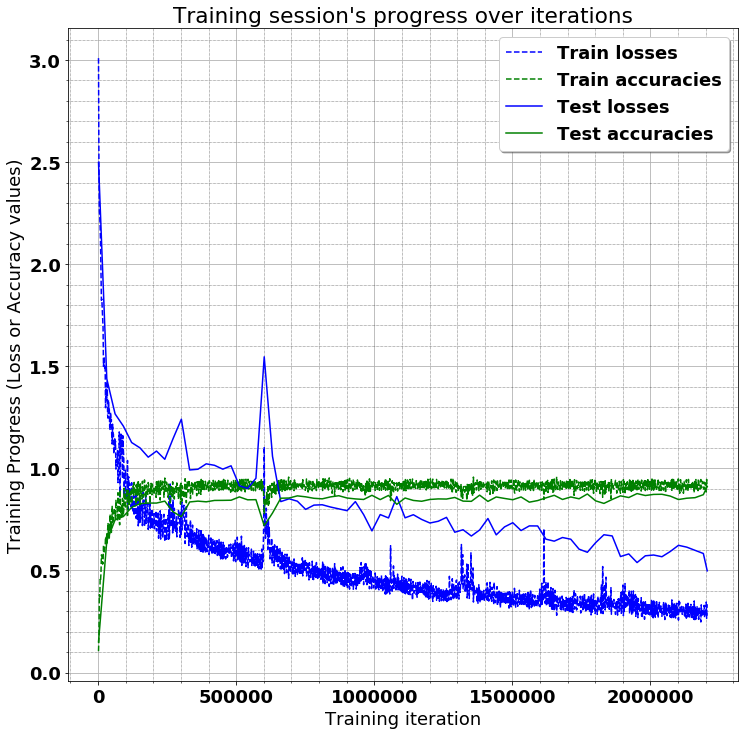

In [11]:
# (Inline plots: )
%matplotlib inline

font = {
    'family' : 'Bitstream Vera Sans',
    'weight' : 'bold',
    'size'   : 18
}
matplotlib.rc('font', **font)

width = 12
height = 12
plt.figure(figsize=(width, height))

indep_train_axis = np.array(range(batch_size, (len(train_losses)+1)*batch_size, batch_size))
plt.plot(indep_train_axis, np.array(train_losses),     "b--", label="Train losses")
plt.plot(indep_train_axis, np.array(train_accuracies), "g--", label="Train accuracies")

indep_test_axis = np.append(
    np.array(range(batch_size, len(test_losses)*display_iter, display_iter)[:-1]),
    [training_iters]
)
plt.plot(indep_test_axis, np.array(test_losses),     "b-", label="Test losses")
plt.plot(indep_test_axis, np.array(test_accuracies), "g-", label="Test accuracies")

plt.title("Training session's progress over iterations")
plt.legend(loc='upper right', shadow=True)
plt.ylabel('Training Progress (Loss or Accuracy values)')
plt.xlabel('Training iteration')

plt.grid(True)
plt.grid(True, which='minor', linestyle=':', linewidth='0.5', color='black')
plt.minorticks_on()
plt.show()

In [ ]:
# Results

predictions = one_hot_predictions.argmax(1)

print("Testing Accuracy: {}%".format(100*accuracy))

print("")
print("Precision: {}%".format(100*metrics.precision_score(y_test, predictions, average="weighted")))
print("Recall: {}%".format(100*metrics.recall_score(y_test, predictions, average="weighted")))
print("f1_score: {}%".format(100*metrics.f1_score(y_test, predictions, average="weighted")))

print("")
print("Confusion Matrix:")
confusion_matrix = metrics.confusion_matrix(y_test, predictions)
print(confusion_matrix)
normalised_confusion_matrix = np.array(confusion_matrix, dtype=np.float32)/np.sum(confusion_matrix)*100

print("")
print("Confusion matrix (normalised to % of total test data):")
print(normalised_confusion_matrix)
print("Note: training and testing data is not equally distributed amongst classes, ")
print("so it is normal that more than a 6th of the data is correctly classifier in the last category.")

# Plot Results:
width = 12
height = 12
plt.figure(figsize=(width, height))
plt.imshow(
    normalised_confusion_matrix,
    interpolation='nearest',
    cmap='RdBu'
)
plt.title("Confusion matrix \n(normalised to % of total test data)")
plt.colorbar()
tick_marks = np.arange(n_classes)
plt.xticks(tick_marks, LABELS, rotation=90)
plt.yticks(tick_marks, LABELS)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()